In [1]:
import os
# from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
from matplotlib.colors import BoundaryNorm, LogNorm
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.ticker import MaxNLocator
import pandas as pd
import datetime
from mpl_toolkits.mplot3d import Axes3D, axes3d

# import pandas as pd
import xarray as xr
from scipy import signal, integrate, stats
from waveletFunctions import wave_signif, wavelet
# from statistics import linear_regression

from palettable.mycarta import Cube1_10

import subroutines
import vis_eulag

plt.style.use('latex_default.mplstyle')

In [2]:
SETTINGS = vis_eulag.load_settings('settings_local_translb.txt')
fileLocations = ['/work/bd0620/b309199/translb3D/translb3D_003', '/work/bd0620/b309199/translb3D/translb3D_005',
                 '/work/bd0620/b309199/translb3D/translb3D_004', '/work/bd0620/b309199/translb3D/translb3D_006',
                 '/work/bd0620/b309199/translb3D/translb3D_008', '/work/bd0620/b309199/translb3D/translb3D_007']
labels=['PNJ above TD', 'L: 400km', 'L: 300km', 'L: 200km', r'U$\mathbf{_{max}}$: 130ms$\mathbf{^{-1}}$', 'NW-SE TD']

ds_list = []
for fileLocation in fileLocations:
    env_fileName = "env.nc"
    tapes_fileName = "tapes.nc" # "tapes.nc"
    grid_fileName = "grd.nc"
    env_path = os.path.join(fileLocation, env_fileName)
    tapes_path = os.path.join(fileLocation, tapes_fileName)
    grid_path = os.path.join(fileLocation, grid_fileName)

    ds = xr.open_dataset(tapes_path) #, decode_times=False)
    # DS['alt_plot'] = (DS.altitude + DS.altitude_offset + DS.station_height) / 1000 #km
    # DS.temperature.values = np.where(DS.temperature == 0, np.nan, DS.temperature) # Change 0 to NaN

    ds_grid = xr.open_dataset(grid_path)
    ds_env = xr.open_dataset(env_path)

    if len(ds.w.shape) == 3: # 2D case
        # ds_env['time'] = ds['time']
        ds = ds.drop('time')
        ds['ELEVATION'] = ds['ELEVATION'].expand_dims({'t':ds.t})
        # ds = ds.drop('ELEVATION')
        ds = ds.expand_dims('y',axis=2)

    if len(ds_env.ue.shape) == 3: # not time depedant case
        ds_env = ds_env.expand_dims({'t':ds.t})

    ds = ds.assign_coords({'xcr':ds_grid['xcr']/1000, 'zcr':ds_env['zcr']/1000, 'ycr':ds_grid['ycr']/1000,
                          'zs':ds_grid['zs']/1000, 'zh':ds_grid['zh']/1000, 'gi':ds_grid['gi']})
    ds_env = ds_env.drop('zcr')
    ds = ds.merge(ds_env)

    # ---- Sim parameters -------------- # 
    ds.attrs = ds_grid.attrs
    ds.attrs['bv'] = ds.attrs['bv'].round(3)
    ds.attrs['u00'] = ds['ue'][0,0,0,0].values
    ds.attrs['v00'] = ds['ve'][0,0,0,0].values
    ds.attrs['nx'] = np.shape(ds['w'])[3]
    ds.attrs['ny'] = np.shape(ds['w'])[2]
    ds.attrs['nz'] = np.shape(ds['w'])[1]
    
    ds = subroutines.dzdx_topo(ds)
    # ---- Sim parameters -------------- # 

    # ---- Constants ------------------- #
    pref00=101325.
    # pref00=23700.
    ds.attrs['cp']=3.5*ds.rg # Earth
    ds.attrs['grav']=ds.g
    ds.attrs['cap']=ds.rg/ds.cp
    ds.attrs['capi'] =1/ds.cap
    ds.attrs['capp']=1-ds.cap # Cv/Cp
    ds.attrs['cappi']=1/ds.capp   # Cp/Cv
    ds.attrs['compri']=ds.rg/pref00**ds.cap
    # ---- Constants ------------------- # 

    # ---- IDL code of AD -------------- # 
    # Forces (MF_x, EF_z, EF_x)
    # h1: ttt (theta)
    # h2: tloc-tte with tloc = thloc*(ploc/pref00)^cap
    # h3: wprime = w
    # h4: tprime+the
    # h5: sqrt(uprime^2+vprime^2)
    # h6: uprime
    # h7: ploc or h12-h12(100), h12=p
    # h9: MFx
    # h11: EFx
    # h12: pprime filtered
    # ---- IDL code of AD -------------- #

    # ---- Perturbations -- #
    # Uncomment line that suits available data
    # ds['uprime'] = ds['u'] - ds['u'][:,:,:,0] # time-dependant background state
    # ds['uprime'] = ds['u'] - ds['ue']

    # ds['vprime'] = ds['v'] - ds['ve'][:,:,:,0] # time-dependant background state
    # ds['vprime'] = ds['v'] - ds['ve']

    # ds['wprime'] = ds['w']
    
    # ---- Pressure ------- #
    ds['pref00'] = ds['pr0'].max() # Pa pref00=101325.
    # p is pressure perturbation output from EULAG
    # h12 is 2D filtered
    # h7 additionally referenced to x-location before mtn
    # ppe=(rhe*the*compri)^cappi
    ds['pprime']=ds['p'] # h12
    # ds['pprime']=filt_2dx(ds['p'],1) # h12
    # ds['pprime']=filt_2dx(ds['p'],0) # h12
    # ds['ploc'] = ds['pprime'] + ds['pr0']
    # ds['h7'] = ds['pprime'] - ds['pprime'][:,:,:,100] # x=100 before mtn?

    ds_cp = ds.copy()
    ds_list.append(ds_cp)

In [3]:
def omega(k,l,m):
    f=-1.195e-4 # 55°S
    N=0.02
    H=7000
    omega = ((N**2*(k**2+l**2) + f**2*(m**2+1/(4*H**2)))/(k**2+l**2+m**2+1/(4*H**2)))**(0.5)
    return omega

f=-1.195e-4 # 55°S
ki = 2*np.pi / (750*1000)
li = 2*np.pi / (600*1000)
mi = 2*np.pi / (12*1000)
omega_intrinsic = omega(ki,li,mi)

print('Omega: ', omega_intrinsic)
print('f: ', f)
print('Faktor: ', 1-f**2/omega_intrinsic**2)

Omega:  0.0005212592577387335
f:  -0.0001195
Faktor:  0.9474432806750112


[27. 30. 33. 36. 39. 42. 45. 48. 51. 54.]
[ 6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26.]
Sim:  0
Sim:  1
Sim:  2
Sim:  3
Sim:  4
Sim:  5


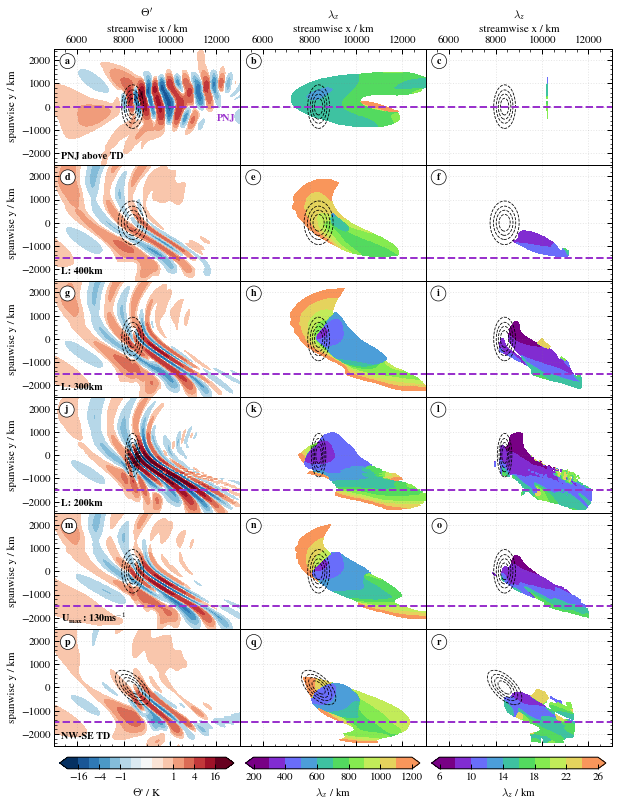

In [4]:
# --- Wavelet analysis (2D zonal wavelength) --- #
# fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(2,2,figsize=(12,9),sharey=True)
# plt.grid(b=True, color='grey', alpha=0.2, linestyle=':', linewidth=2)
# gskw = {'left':0,'bottom':0,'right':1,'top':1,'wspace':0,'hspace':0,'height_ratios': [10,10,10,10,10,2]}
gskw = {'wspace':0,'hspace':0,'height_ratios': [10,10,10,10,10,10,2]}
fig, axes = plt.subplots(7,3,figsize=(10,13.25),sharex=True,sharey=True,gridspec_kw=gskw)
axes[0,0].xaxis.set_minor_locator(AutoMinorLocator())
axes[0,0].yaxis.set_minor_locator(AutoMinorLocator())

# - Colormaps - # 
cmap = Cube1_10.mpl_colormap
# clev = [250,300,350,400,450,500,550,600,700,800,900,1000,1100,1200]
clev = [200,300,400,500,600,700,800,900,1000,1100,1200]
# clev = [6,8,10,12,14,16,18,20,25,35,55]
norm = BoundaryNorm(boundaries=clev,ncolors=cmap.N,clip=True)

clev_angle = np.linspace(27,54,10)
print(clev_angle)
norm_angle = BoundaryNorm(boundaries=clev_angle,ncolors=cmap.N,clip=True)

clev_z = np.linspace(6,26,11)
print(clev_z)
norm_z = BoundaryNorm(boundaries=clev_z,ncolors=cmap.N,clip=True)

cmap_th = plt.get_cmap('RdBu_r')
clev_th, clev_l_th = subroutines.get_colormap_bins_and_labels(max_level=32)
norm_th = BoundaryNorm(boundaries=clev_th, ncolors=cmap_th.N, clip=True)

# - Parameters for plots - #
t=6
z=133 # 40km (dz=300m)
# z=100 # 30km
z_l = 40 # km
nx_avg = int(600*1000/ds.dx00) # lambda filter = 600km

mother = 'MORLET'
lag1 = 0.72  # lag-1 autocorrelation for red noise background
sig_lev = 1


calc_lambdaz = True
mfx_option='obs'
mfx_o = []
mfx_s = []
mfy_o = []
mfy_s = []

numbers = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s'] # s -> 17
j = 0
for ds in ds_list:
    # ---- Calculations ---- #
    print('Sim: ', j)
    
    if j==0:
        y_jet = 0 # km
    else:
        y_jet = -1500 # km
                         
    data=ds['th'][t,z,:,:].values
    variance = np.std(data, ddof=1) ** 2
    
    
    # - Coriolis and dthdz for angular momentum flux calculation - #
    f = ds.fcr0 * np.sin(ds.ang*np.pi/180)
    
    z_coord = np.linspace(0,ds.zcr[0,-1,0,0],ds.nz)*1000
    the = ds['the'][t,:,:,:]
    the = the.assign_coords(z_coord = ("z",z_coord))
    dthdz = the.differentiate("z_coord")
    
    # -- lambda x -- #
    lambdax = np.zeros(np.shape(data))
    n = ds.nx
    dx = ds.dx00/1000 # km
    # pad = 1  # pad the time series with zeroes (recommended)
    dj = 0.0625  # this will do 4 sub-octaves per octave
    s0 = 2 * dx  # this says start at a scale of 6 months
    j1 = 5 / dj  # this says do 7 powers-of-two with dj sub-octaves each

    for y in range(0,ds.ny):
        wave, period, scale, coi = wavelet(data[y,:], dx, dj=dj, s0=s0, J1=j1, mother=mother)
        power = (np.abs(wave)) ** 2  # / variance # wavelet power spectrum normalized by variance

        # - Significance levels - #
        signif = wave_signif(([variance]), dt=dx, sigtest=0, scale=scale, lag1=lag1, mother=mother)
        # expand signif --> (J+1)x(N) array
        sig95 = signif[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])
        sig95 = power / sig95  # where ratio > 1, power is significant

        # jvec holds indices of maximum power for each x-location
        # indices refer to certain wavelengths
        jvec = np.argmax(power,axis=0)
        xvec = np.arange(0,len(jvec),1)
        lambdax[y,:] = np.where(sig95[jvec,xvec] > sig_lev, period[jvec], np.nan)
        # lambdax[y,:] = np.where(power[jvec,xvec] > E_THRESHOLD, period[jvec], np.nan) # E_THRESHOLD = 25

    # -- lambda y -- #
    lambday = np.zeros(np.shape(data))
    n = ds.ny
    dy = ds.dy00/1000 # km
    # pad = 1  # pad the time series with zeroes (recommended)
    dj = 0.0625  # this will do 4 sub-octaves per octave
    s0 = 2 * dy  # this says start at a scale of 6 months
    j1 = 7 / dj  # this says do 7 powers-of-two with dj sub-octaves each

    for x in range(0,ds.nx):
        wave, period, scale, coi = wavelet(data[:,x], dy, dj=dj, s0=s0, J1=j1, mother=mother)
        power = (np.abs(wave)) ** 2 # / variance # wavelet power spectrum normalized by variance

        # - Significance levels - #
        signif = wave_signif(([variance]), dt=dy, sigtest=0, scale=scale, lag1=lag1, mother=mother)
        # expand signif --> (J+1)x(N) array
        sig95 = signif[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])
        sig95 = power / sig95  # where ratio > 1, power is significant

        # jvec holds indices of maximum power for each x-location
        # indices refer to certain wavelengths
        jvec = np.argmax(power,axis=0)
        yvec = np.arange(0,len(jvec),1)
        lambday[:,x] = np.where(sig95[jvec,yvec] > sig_lev, period[jvec], np.nan)
    
    # - Filter wavelengths - #
    lambdax = np.where(lambdax<1200,lambdax,np.nan)
    lambday = np.where(lambday<1200,lambday,np.nan)
    
    # -- lambda z -- #
    if calc_lambdaz:
        data3D=ds['th'][t,:,:,:].values
        # variance = np.std(data3D, ddof=1) ** 2
        lambdaz = np.zeros(np.shape(data))

        n = ds.nz
        dz = ds.dz00/1000 # km
        # pad = 1  # pad the time series with zeroes (recommended)
        dj = 0.25  # this will do 4 sub-octaves per octave
        # s0 = 8 * dz  # this says start at a scale of 6 months
        # j1 = 4 / dj  # this says do 7 powers-of-two with dj sub-octaves each
        s0 = 2 * dz  # this says start at a scale of 6 months
        j1 = 7 / dj  # this says do 7 powers-of-two with dj sub-octaves each

        for x in range(0,ds.nx):
            for y in range(0,ds.ny):
                if (np.isnan(lambdax[y,x])==False) and (np.isnan(lambday[y,x])==False):
                    wave, period, scale, coi = wavelet(data3D[:,y,x], dz, dj=dj, s0=s0, J1=j1, mother=mother)
                    power = (np.abs(wave)) ** 2 # / variance # wavelet power spectrum normalized by variance
                    
                    # - Significance levels - #
                    signif= wave_signif(([variance]), dt=dz, sigtest=0, scale=scale, lag1=lag1, mother=mother)
                    sig95 = signif[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])
                    sig95 = power / sig95  # where ratio > 1, power is significant
                    
                    jmax = np.argmax(power[:,z])
                    lambdaz[y,x] = np.where(sig95[jmax,z] > sig_lev, period[jmax], np.nan)
                    lambdaz[y,x] = period[jmax]
                else:
                    lambdaz[y,x] = np.nan
    else:
        lambdaz=12
    
    # - Filter wavelengths - #
    lambdaz = np.where(lambdaz<35,lambdaz,np.nan)
    # print('lambdaz: ', np.nanmax(lambdaz))
    
    # - Angle - #
    wave_angle = np.arctan(lambday/lambdax)*180/np.pi
    
    # - Ep - #
    thloc = ds['the'][t,z,:,:] + ds['th'][t,z,:,:] # Theta
    # ds['tloc'] = ds['thloc']*(ds['ploc']/ds['pref00'])**ds.cap
    tte = ds['the'][t,z,:,:]*(ds['pr0'][t,z,:,:]/ds['pref00'])**ds.cap # T_env
    tloc = thloc*(ds['pr0'][t,z,:,:]/ds['pref00'])**ds.cap # T
    tprime = tloc-tte
    # print(tte)
    
    # ep = 1/2*ds['rh0'][t,z,:,:]*(ds.grav/ds.bv)**2 * (tprime/tte)**2 # * ds['rh0'].expand_dims({'t':ds.t}) potential energy density
    ep = 1/2*ds['rh0'][t,z,:,:]*(ds.grav/ds.bv)**2 * (ds['th'][t,z,:,:]/ds['the'][t,z,:,:])**2
    ep=subroutines.fft_gaussian_xy(ep,nx_avg,ny_avg=None)
    
    # - MFx and MFy - #
    mfx_obs = 2 * ep * lambdaz/(-lambdax)
    mfy_obs = 2 * ep * lambdaz/(-lambday)
    # mfx_obs = subroutines.fft_gaussian_xy(mfx_obs,nx_avg,ny_avg=None)
    # mfy_obs = subroutines.fft_gaussian_xy(mfy_obs,nx_avg,ny_avg=None)
    
    # ks = 2*np.pi / (lambdax*1000)
    # ls = 2*np.pi / (lambday*1000)
    # ms = 2*np.pi / (lambdaz*1000)
    # ww = omega(ks,ls,ms)
    # print(ww)
    # (1-(f/ww)**2)
    
    mfx_sim = ds['rh0'][t,z,:,:] * ds['w'][t,z,:,:] * (ds['u'][t,z,:,:]-ds['ue'][t,z,:,:]) 
    mfy_sim = ds['rh0'][t,z,:,:] * ds['w'][t,z,:,:] * (ds['v'][t,z,:,:]-ds['ve'][t,z,:,:])
    # mfx_sim = ds['rh0'][t,z,:,:] * (ds['w'][t,z,:,:] * (ds['u'][t,z,:,:]-ds['ue'][t,z,:,:]) - f * (ds['v'][t,z,:,:]-ds['ve'][t,z,:,:]) * ds['th'][t,z,:,:] / dthdz[z,:,:]) 
    # mfy_sim = ds['rh0'][t,z,:,:] * (ds['w'][t,z,:,:] * (ds['v'][t,z,:,:]-ds['ve'][t,z,:,:]) + f * (ds['u'][t,z,:,:]-ds['ue'][t,z,:,:]) * ds['th'][t,z,:,:] / dthdz[z,:,:])
    mfx_sim = subroutines.fft_gaussian_xy(mfx_sim,nx_avg,ny_avg=None)
    mfy_sim = subroutines.fft_gaussian_xy(mfy_sim,nx_avg,ny_avg=None)
    
    if mfx_option=='obs':
        mfx=mfx_obs
        mfy=mfy_obs
    else:
        mfx=mfx_sim
        mfy=mfy_sim
    
    # - Save list of arrays for scatter plot - #
    mfx_o.append(mfx_obs.values.flatten())
    mfx_s.append(mfx_sim.values.flatten())
    mfy_o.append(mfy_obs.values.flatten())
    mfy_s.append(mfy_sim.values.flatten())
    
    # - FOR PLOTTING - #
    # ep   = np.where(np.abs(ep)>0.1,ep,np.nan)
    # mfx  = np.where(np.abs(mfx*1000)>0.002,mfx,np.nan)
    # mfy  = np.where(np.abs(mfy*1000)>0.002,mfy,np.nan)
    
    # ---- Plotting ---- #
    data = np.where(np.abs(data)>0.5,data,np.nan) # white background
    contf_th = axes[j,0].contourf(ds.xcr[0,:],ds.ycr[:,0],data,cmap=cmap_th,norm=norm_th,levels=clev_th,extend='both')
    # contf = axes[j,0].contourf(ds.xcr[0,:],ds.ycr[:,0],data,cmap='RdBu_r')
    contf = axes[j,1].contourf(ds.xcr[0,:],ds.ycr[:,0],lambdax,cmap=Cube1_10.mpl_colormap,norm=norm,levels=clev,extend='both')
    contf_z = axes[j,2].contourf(ds.xcr[0,:],ds.ycr[:,0],lambdaz,cmap=Cube1_10.mpl_colormap,norm=norm_z,levels=clev_z,extend='both')
    # hatch = axes[j,1].contourf(ds.xcr[0,:],ds.ycr[:,0],lambdaz,levels=[6,20], colors='none',
    #                               hatches=['xxx',None,'xxx'],extend='both')
    # hatch1 = axes[j,2].contourf(ds.xcr[0,:],ds.ycr[:,0],wave_angle,levels=[30,360], colors='none',
    #                               hatches=['xxx',None,'xxx'],extend='both')
    # cont  = axes[j,1].contour(ds.xcr[0,:],ds.ycr[:,0],lambdaz,levels=[12,18],colors='k',lw=2)
    # axes[j,1].clabel(cont,[12,18],inline_spacing=1, inline=True)
    axes[j,0] = subroutines.format_xy_plot(ds, SETTINGS, axes[j,0], t, z=z)
    axes[j,1] = subroutines.format_xy_plot(ds, SETTINGS, axes[j,1], t, z=z)
    axes[j,2] = subroutines.format_xy_plot(ds, SETTINGS, axes[j,2], t, z=z)
    
    # - PNJ - #
    axes[j,0].hlines(y=y_jet,xmin=ds.xcr.min(),xmax=ds.xcr.max(), linestyles='--', lw=2, colors='darkorchid')
    axes[j,1].hlines(y=y_jet,xmin=ds.xcr.min(),xmax=ds.xcr.max(), linestyles='--', lw=2, colors='darkorchid')
    axes[j,2].hlines(y=y_jet,xmin=ds.xcr.min(),xmax=ds.xcr.max(), linestyles='--', lw=2, colors='darkorchid')
    
    # Numbering 
    axes[j,0].text(0.06, 0.87, numbers[3*j], horizontalalignment='left', transform=axes[j,0].transAxes, weight='bold', bbox={"boxstyle" : "circle", "lw":0.67, "facecolor":"white", "edgecolor":"black"})
    axes[j,1].text(0.06, 0.87, numbers[3*j+1], horizontalalignment='left', transform=axes[j,1].transAxes, weight='bold', bbox={"boxstyle" : "circle", "lw":0.67, "facecolor":"white", "edgecolor":"black"})
    axes[j,2].text(0.06, 0.87, numbers[3*j+2], horizontalalignment='left', transform=axes[j,2].transAxes, weight='bold', bbox={"boxstyle" : "circle", "lw":0.67, "facecolor":"white", "edgecolor":"black"})

    
    # - Axes - #
    axes[j,0].set_ylabel('spanwise y / km')
    axes[j,0].axis('scaled')
    axes[j,1].axis('scaled')
    axes[j,2].axis('scaled')
    axes[j,0].grid()
    axes[j,1].grid()
    axes[j,2].grid()
    axes[j,0].tick_params(which='both',bottom=False,top=False,right=False,direction='in')
    axes[j,1].tick_params(which='both',bottom=False,top=False,left=False,right=False,direction='in')
    axes[j,2].tick_params(which='both',bottom=False,top=False,left=False,direction='in')
    
    axes[j,0].text(0.04,0.06, labels[j], transform=axes[j,0].transAxes, weight='bold')
    
    j += 1

if ds.irely:
    # ny_sponge=int(ds.dyab/ds.dx00)
    axes[0,0].set_ylim(ds.ycr.min()+ds.dyab/1000,ds.ycr.max()-ds.dyab/1000)
    axes[0,0].set_ylim(-2500,2500)
axes[0,0].set_xlim(5000,13000)
axes[0,0].set_xticks([6000,8000,10000,12000])

axes[0,0].set_title(r"$\Theta'$")
axes[0,1].set_title('$\lambda_x$')
axes[0,2].set_title('$\lambda_z$')

axes[0,0].set_xlabel('streamwise x / km')
axes[0,1].set_xlabel('streamwise x / km')
axes[0,2].set_xlabel('streamwise x / km')

axes[0,0].xaxis.set_label_position('top') 
axes[0,1].xaxis.set_label_position('top')
axes[0,2].xaxis.set_label_position('top')

ilast = 6
axes[0,0].tick_params(which='both',top=True,direction='in',labelbottom=False,labeltop=True)
axes[0,1].tick_params(which='both',top=True,direction='in',labelbottom=False,labeltop=True)
axes[0,2].tick_params(which='both',top=True,direction='in',labelbottom=False,labeltop=True)
axes[ilast-1,0].tick_params(which='both',bottom=True,direction='in',labelbottom=False,labeltop=False)
axes[ilast-1,1].tick_params(which='both',bottom=True,direction='in',labelbottom=False,labeltop=False)
axes[ilast-1,2].tick_params(which='both',bottom=True,direction='in',labelbottom=False,labeltop=False)

axes[ilast,0].axis('off')
axes[ilast,1].axis('off')
axes[ilast,2].axis('off')
cbar = fig.colorbar(contf_th, ax=axes[ilast,0], orientation='horizontal', ticks=clev_l_th, fraction=0.5,aspect=15) # anchor=(0,0)
cbar.set_label(r"$\Theta$' / K")
cbar = fig.colorbar(contf, ax=axes[ilast,1], orientation='horizontal', fraction=0.5,aspect=15)
cbar.set_label('$\lambda_x$ / km')
cbar = fig.colorbar(contf_z, ax=axes[ilast,2], orientation='horizontal', fraction=0.5,aspect=15)
cbar.set_label('$\lambda_z$ / km')
    
# axes[0,0].text(0.04,0.06,'Z: ' + str(z_l) + 'km', transform=axes[0,0].transAxes, weight='bold')
axes[0,0].annotate('PNJ',(12000,0-600), weight='bold',color='darkorchid')

# plt.subplot_tool()

# --- Save figure --- #
# fig.suptitle(title_label)
fig_folder = '../figures/'
fig_title  = 'waveletAna_overview' + '.png'
# fig.tight_layout()
fig.savefig(fig_folder + fig_title, facecolor='w', edgecolor='w',
             format='png', dpi=450, bbox_inches='tight')

-0.2246717331547086
1.2273052612548454
1.1891229713626816
1.0203875578557273
1.212305322569626
1.1432935591962496


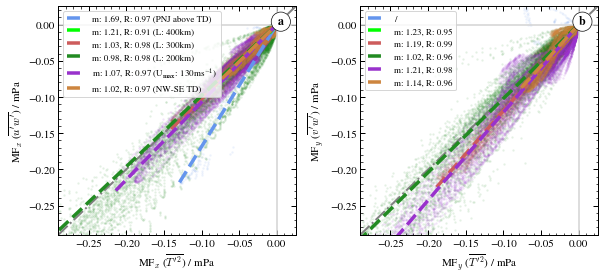

In [7]:
fig, axes = plt.subplots(1,2,figsize=(8.5,4))
# eventually do for two alt levels in same plot with different colors with two fits
# check how momentum flux could be included in wavelet ana... maybe with colored dashed lines mfx and mfy?? could work since its only
# small statement

lws=3.5
cols = ['cornflowerblue','lime','indianred','forestgreen','darkorchid', 'peru']
# xlims = [-6e-1,5e-2]
xlims = [-2.9e-1,2.5e-2]
ss = 10
symb = '.'

#### slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)


ax = axes[0]
# - Diagonal - #
ax.plot([0, 1], [0, 1], c='grey', ls='-.',lw=lws-1.5, transform=ax.transAxes)
ax.axvline(x=0, c='lightgrey', ls='-',lw=lws-2)
ax.axhline(y=0, c='lightgrey', ls='-',lw=lws-2)
ax.text(0.95, 0.92, 'a', horizontalalignment='right', fontsize=12, transform=ax.transAxes, weight='bold', bbox={"boxstyle" : "circle", "lw":0.67, "facecolor":"white", "edgecolor":"black"})
# ax.grid()

for isim in range(0,6):
    mf_sim = mfx_s[isim]
    mf_obs = mfx_o[isim]
    ax.scatter(1000*mf_obs,1000*mf_sim,marker=symb, s=ss, c=cols[isim], alpha=0.07)
    # ax.scatter(1000*mf_obs,1000*mf_sim,marker=symb, s=ss, c='k', alpha=0.07)

for isim in range(0,6):
    mf_sim = mfx_s[isim]
    mf_obs = mfx_o[isim]
    
    # - Linear fit - #
    idx = np.isfinite(mf_obs) & np.isfinite(mf_sim)
    slope, intercept, r_value, p_value, std_err = stats.linregress(1000*mf_obs[idx], 1000*mf_sim[idx])
    slope, _, _, _ = np.linalg.lstsq(1000*mf_obs[idx,np.newaxis], 1000*mf_sim[idx])
    slope=slope[0]
    # coef = np.polyfit(1000*mf_obs[idx], 1000*mf_sim[idx], 1)
    # poly1d_fn = np.poly1d(coef) # poly1d_fn is now a function which takes in x and returns an estimate for y
    # lab = str(round(coef[0],2)) + ' (' + labels[isim] + ')'
    lab = 'm: ' + str(round(slope,2)) + ', R: ' + str(round(r_value,2)) + ' (' + labels[isim] + ')'
    
    x_fit = np.linspace(np.nanmin(1000*mf_obs), np.nanmax(1000*mf_obs),50)
    # y_fit = slope * x_fit + intercept
    y_fit = slope * x_fit
    ax.plot(x_fit, y_fit, lw=lws, ls='--', c=cols[isim], label=lab)
    # ax.text(0.05,0.9,'Slope: ' + str(round(coef[0],2)),transform=ax.transAxes)

ax.set_xlim(xlims)
ax.set_ylim(xlims)
ax.set_xlabel("MF$_x$ ($\overline{T'^2}$) / mPa")
ax.set_ylabel("MF$_x$ ($\overline{u'w'}$) / mPa")
ax.legend(loc='upper left', fontsize=9)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax = axes[1]
# - Diagonal - #
ax.plot([0, 1], [0, 1], c='grey', ls='-.',lw=lws-1.5, transform=ax.transAxes)
ax.axvline(x=0, c='lightgrey', ls='-',lw=lws-2)
ax.axhline(y=0, c='lightgrey', ls='-',lw=lws-2)
ax.text(0.95, 0.92, 'b', horizontalalignment='right', fontsize=12, transform=ax.transAxes, weight='bold', bbox={"boxstyle" : "circle", "lw":0.67, "facecolor":"white", "edgecolor":"black"})
# ax.grid()

for isim in range(0,6):
    mf_sim = mfy_s[isim]
    mf_obs = mfy_o[isim]
    ax.scatter(1000*mf_obs,1000*mf_sim,marker=symb, s=ss, c=cols[isim], alpha=0.07)
    # ax.scatter(1000*mf_obs,1000*mf_sim,marker=symb, s=ss, c='k', alpha=0.07)

for isim in range(0,6):
    mf_sim = mfy_s[isim]
    mf_obs = mfy_o[isim]
    
    # - Linear fit - #
    idx = np.isfinite(mf_obs) & np.isfinite(mf_sim)
    # coef = np.polyfit(1000*mf_obs[idx], 1000*mf_sim[idx], 1)
    # poly1d_fn = np.poly1d(coef)
    slope, intercept, r_value, p_value, std_err = stats.linregress(1000*mf_obs[idx], 1000*mf_sim[idx])
    # slope, intercept = linear_regression(1000*mf_obs[idx], 1000*mf_sim[idx], proportional=True)
    slope, _, _, _ = np.linalg.lstsq(1000*mf_obs[idx,np.newaxis], 1000*mf_sim[idx])
    slope=slope[0]
    x_fit = np.linspace(np.nanmin(1000*mf_obs), np.nanmax(1000*mf_obs),50)
    # y_fit = slope * x_fit + intercept
    y_fit = slope * x_fit
    print(slope)
    lab = 'm: ' + str(round(slope,2)) + ', R: ' + str(round(r_value,2))
    
    if isim==0:
        ax.plot(0*x_fit, 0*y_fit, lw=lws, ls='--', c=cols[isim], label='/')
    else:
        ax.plot(x_fit, y_fit, lw=lws, ls='--', c=cols[isim], label=lab)

ax.set_xlim(xlims)
ax.set_ylim(xlims)
ax.set_xlabel("MF$_y$ ($\overline{T'^2}$) / mPa")
ax.set_ylabel("MF$_y$ ($\overline{v'w'}$) / mPa")
ax.legend(loc='upper left',fontsize=9)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

fig_folder = '../figures/'
fig_title  = 'waveletAna_mf_scatter' + '.png'
fig.tight_layout()
fig.savefig(fig_folder + fig_title, facecolor='w', edgecolor='w',
             format='png', dpi=450, bbox_inches='tight')

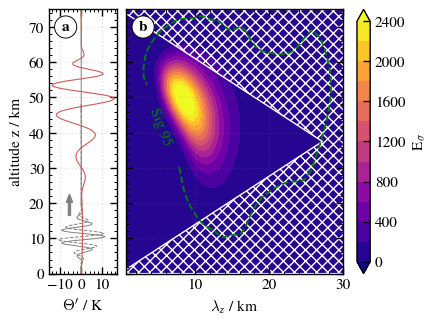

In [41]:
# --- Wavelet analysis (Power spectrum) --- #
plt.style.use('latex_default.mplstyle')
t=6
z=133 # 40km (dz=300m)
# x=int(ds.nx/2)
x=int(9400*1000/ds.dx00)
ds = ds_list[2]
y = int(ds.ny/3+40)
# y = int(ds.ny/2)

n = ds.nz
dz = ds.dz00/1000 # km
dj = 0.0625  # this will do 4 sub-octaves per octave
s0 = 2 * dz  # this says start at a scale of 6 months
j1 = 7 / dj  # this says do 7 powers-of-two with dj sub-octaves each
mother = 'MORLET'

# The normalization by 1/σ2 gives a measure of the power relative to white noise
# lambda = scale*1.03 = 'period'
# wavelet(Y, dt, pad=0, dj=-1, s0=-1, J1=-1, mother=-1, param=-1, freq=None):

data=ds['th'][t,:,y,x].values
variance = np.std(ds['th'][t,:,:,:].values, ddof=1) ** 2
wave, period, scale, coi = wavelet(data, dz, dj=dj, s0=s0, J1=j1, mother=mother)
power = (np.abs(wave)) ** 2 / variance # wavelet power spectrum normalized by variance

# - Significance levels - #
signif= wave_signif(([variance]), dt=dz, sigtest=0, scale=scale, lag1=lag1, mother=mother)
sig95 = signif[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])
sig95 = power / sig95  # where ratio > 1, power is significant

gskw = {'wspace':0.05,'width_ratios': [1,4]}
fig, axes = plt.subplots(1,2,figsize=(4.5,3.5),sharey=True, gridspec_kw=gskw)

ax = axes[0]
mor = signal.morlet(ds.nz, w=5.0, s=2.0, complete=False)
ax.plot(15*mor.imag,ds.zcr[t,:,y,x]-27,c='grey', ls='--',lw=0.7)
ax.plot(15*mor.real,ds.zcr[t,:,y,x]-27,c='grey', ls='-',lw=0.7)
ax.plot(15*mor.real,ds.zcr[t,:,y,x]+46,c='grey', ls='-',lw=0.7)
ax.arrow(0.3, 0.22, 0, 0.05, width = 0.03, head_length=0.03, transform=ax.transAxes, facecolor='grey', edgecolor='grey')

ax.plot(ds['th'][t,:,y,x], ds.zcr[t,:,y,x],c='indianred')
ax.set_ylabel('altitude z / km')
ax.set_xlabel("$\Theta'$ / K")
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.grid()
ax.text(0.3, 0.92, 'a', horizontalalignment='right', transform=ax.transAxes, weight='bold', bbox={"boxstyle" : "circle", "lw":0.67, "facecolor":"white", "edgecolor":"black"})

ax = axes[1]
levels = np.linspace(200,2400,12)
levels = np.linspace(0,2400,13)
contf = ax.contourf(period,ds.zcr[t,:,y,x],power.T,cmap='plasma', extend='both', levels=levels)
cont = ax.contour(period,ds.zcr[t,:,y,x],sig95.T,levels=[0,1], colors='green', linestyles='--', linewidths=1.3)
ax.clabel(cont,[0,1],inline_spacing=1, fmt={0:'0',1:'Sig 95'}, inline=True)
# ax.plot(coi,ds.zcr[t,:,y,x],color='white',lw=2)
cbar = fig.colorbar(contf, ax=ax, shrink=1)
cbar.set_label('E$_{\sigma}$')

ax.fill_betweenx(ds.zcr[t,:,y,x], 32, coi, facecolor='None', alpha=1, hatch='xxx', edgecolor='white')
# ax.fill_betweenx(ds.zcr[t,:,y,x], 32, coi, color='white', hatch='xxx')


ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid()
ax.text(0.1, 0.92, 'b', horizontalalignment='right', transform=ax.transAxes, weight='bold', bbox={"boxstyle" : "circle", "lw":0.67, "facecolor":"white", "edgecolor":"black"})

ax.set_xlim(2*dz,30)
ax.set_ylim(0,75)
ax.set_xlabel('$\lambda_z$ / km')

# --- Save figure --- #
fig_folder = '../figures/'
fig_title  = 'waveletAna_power_spectrum' + '.png'
fig.tight_layout()
fig.savefig(fig_folder + fig_title, facecolor='w', edgecolor='w',
             format='png', dpi=450, bbox_inches='tight')

In [ ]:
## maybe show cone of interest for vertical analysis with a vertical cross-section and a line through it

# - Sorting - #
# zipped_lists = zip(1000*mfx_obs.values.flatten(), 1000*mfx_sim.values.flatten())
# sorted_pairs = sorted(zipped_lists)
# tuples = zip(*sorted_pairs)
# mfx_o, mfx_s = [ list(tuple) for tuple in  tuples]

# z_coord = np.linspace(0,ds.zcr[0,-1,0,0],ds.nz)*1000
# th = ds['th'][6,:,:,:]
# th = th.assign_coords(z_coord = ("z",z_coord))
# dthdz = th.differentiate("z_coord")

In [4]:
# ---- Check Ern method (mid-frequency approximation) for larger f ---- #
global N,H,cs,g,f,gamma
N = 0.02
H  = 7000
cs = 310 # 343
g  = 9.81
f  = 2*7.292e-5*np.sin(55*np.pi/180)
# f = 0.00012
gamma = 1.4

print('f:', f)
print(g/cs**2)
print(1/H-N**2/g)
def omega(k,l,m):
    omega = ((N**2*(k**2+l**2) + f**2*(m**2+1/(4*H**2)))/(k**2+l**2+m**2+1/(4*H**2)))**(0.5)
    return omega

def beta(k,l,m):
    beta = -omega(k,l,m)/(N**2-omega(k,l,m)**2) * complex(m,1/(2*H)-g/cs**2)
    return beta

def A(k,l,m):
    A = (1-omega(k,l,m)**2/N**2) * (1+1/m**2*(1/(2*H)-g/cs**2)**2)**(-1) * (1+(f/(m*omega(k,l,m)))**2*(1/(2*H)-g/cs**2)**2)**(0.5)
    return A

def B(k,l,m):
    B = abs(complex(1, 1/beta(k,l,m) * (gamma-1)/cs**2 * omega(k,l,m)/(N**2/g)))**(-2)
    return B

nx = 200
nz = 150
lambdax = np.linspace(1,680,nx)
lambdaz = np.linspace(1,50,nz)
ks = 2*np.pi / (lambdax*1000)
l = 0
ms = 2*np.pi / (lambdaz*1000)

factor_A = np.ones((nx,nz))
factor_B = np.ones((nx,nz))

for i,k in enumerate(ks):
    for j,m in enumerate(ms):
        factor_A[i,j] = A(k,l,m)
        factor_B[i,j] = B(k,l,m)
factor_AB = factor_A.copy() * factor_B.copy()

# - f (ern) - #
f  = 2*7.292e-5*np.sin(30*np.pi/180)
factor_A = np.ones((nx,nz))
factor_B = np.ones((nx,nz))
for i,k in enumerate(ks):
    for j,m in enumerate(ms):
        factor_A[i,j] = A(k,l,m)
        factor_B[i,j] = B(k,l,m)
factor_AB_ern = factor_A * factor_B

f: 0.00011946513413910657
0.00010208116545265349
0.00010208242318334063


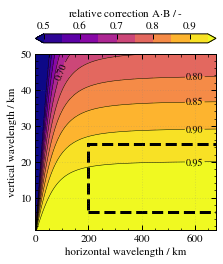

In [29]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(1,1,figsize=(3.2,3.8))
levels = np.arange(0.5,1,0.05)
contf = ax.contourf(lambdax,lambdaz,factor_AB.T,cmap='plasma',levels=levels,extend='both')
cbar = fig.colorbar(contf, ax=ax, location='top', ticks=[0.5,0.6,0.7,0.8,0.9])

# cont     = ax.contour(lambdax,lambdaz,factor_AB.T,levels=levels, colors='k', linewidths=0.5)
cont_ern = ax.contour(lambdax,lambdaz,factor_AB_ern.T,levels=levels, colors='k', linewidths=0.5)
# ax.clabel(cont, cont.levels, inline=True)
wind_z_pos = np.linspace(20,45,4)
wind_label = []
for pos in wind_z_pos:
    wind_label.append((600,pos))
wind_label.append((100,45))
ax.clabel(cont_ern, cont_ern.levels, inline=True, inline_spacing=1, manual=wind_label)

ax.add_patch(Rectangle((200,6), 600, 19,edgecolor='black', fill=False,lw=3,ls='--'))

ax.set_xlabel('horizontal wavelength / km')
ax.set_ylabel('vertical wavelength / km')
cbar.set_label('relative correction A$\cdot$B / -')

ax.set_xlim((0,680))
# ax.set_ylim(xlims)

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid()

# --- Save figure --- #
fig_folder = '../figures/'
fig_title  = 'waveletAna_mfcorrection_factor' + '.png'
fig.tight_layout()
fig.savefig(fig_folder + fig_title, facecolor='w', edgecolor='w',
             format='png', dpi=450, bbox_inches='tight')